In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error
import math


In [33]:
train_data_raw =  pd.read_csv("Gasleak Data Sets/sensor_readings.csv")
train_data_raw.columns = ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]

In [34]:
test_data_raw = pd.read_csv("Gasleak Data Sets/validation_files/sensor_readings.csv")
test_data_raw.columns =  ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]

In [35]:
leak_data_raw = pd.concat([train_data_raw, test_data_raw], ignore_index=True)
leak_data = leak_data_raw.copy()
leak_data = leak_data.drop(['temp'], axis=1)
leak_data['Time'] -= 1681776002
leak_data['Sum'] = leak_data.iloc[:,1:].sum(axis=1)
leak_data['Mean'] = leak_data.iloc[:,1:-1].mean(axis=1)

In [37]:
scaler = MinMaxScaler(feature_range=(-1, 1))
leak_data['Normalized Sum'] = scaler.fit_transform(leak_data['Sum'].values.reshape(-1,1))
leak_data['Normalized Mean'] = scaler.fit_transform(leak_data['Mean'].values.reshape(-1,1))
leak_data['Normalized Sensor 1'] = scaler.fit_transform(leak_data['Sensor 1'].values.reshape(-1,1))

# leak_data
# plt.plot()

In [38]:
def load_data(feature, look_back):
    data_raw = feature.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
feature =  leak_data[['Normalized Sensor 1']] # have to put in two brackets because
x_train, y_train, x_test, y_test = load_data(feature, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (133713, 59, 1)
y_train.shape =  (133713, 1)
x_test.shape =  (33428, 59, 1)
y_test.shape =  (33428, 1)


In [39]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [8]:
import model as m

input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

model = m.LSTM(input_dim=input_dim,hidden_dim=hidden_dim,num_layers=num_layers,output_dim=output_dim)

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())


LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [11]:
import os

# Train model
num_epochs = 20
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = look_back - 1

# Set the checkpoint parameters
checkpoint_dir = "checkpoints"  # Directory to save checkpoints
checkpoint_interval = 10  # Save a checkpoint every 10 epochs
start_epoch = 0  # Start from this epoch (useful for resuming training)

# Create the checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Load the model state from a checkpoint (if available)
checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{start_epoch}.pth"
if start_epoch > 0 and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimiser.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch}")

for t in range(start_epoch, num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)

    if t % 10 == 0 and t != 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

    # Save a checkpoint
    if (t + 1) % checkpoint_interval == 0:
        checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{t}.pth"
        torch.save({
            "epoch": t,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimiser.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved for epoch {t}")

Checkpoint saved for epoch 9
Epoch  10 MSE:  0.01654644124209881
Checkpoint saved for epoch 19


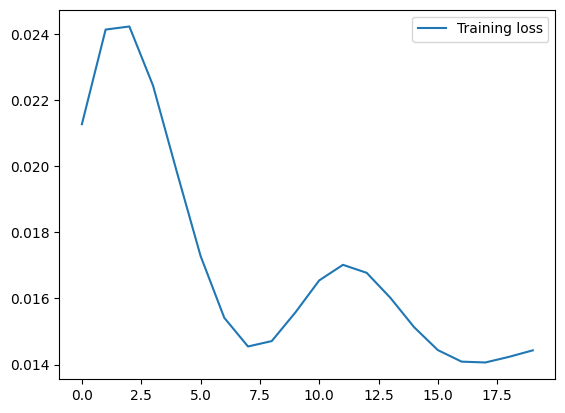

In [12]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [67]:
y_train

array([[-0.5306513 ],
       [-0.5210727 ],
       [-0.4990421 ],
       ...,
       [-0.3850574 ],
       [-0.41379303],
       [-0.40996164]], dtype=float32)

In [71]:
# make predictions
y_test_pred = model(x_test)

# Implement transform
# invert predictions
y_train_pred = (y_train_pred.detach().numpy())
y_train = (y_train.detach().numpy())
y_test_pred = (y_test_pred.detach().numpy())
y_test = (y_test.detach().numpy())


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.55 RMSE


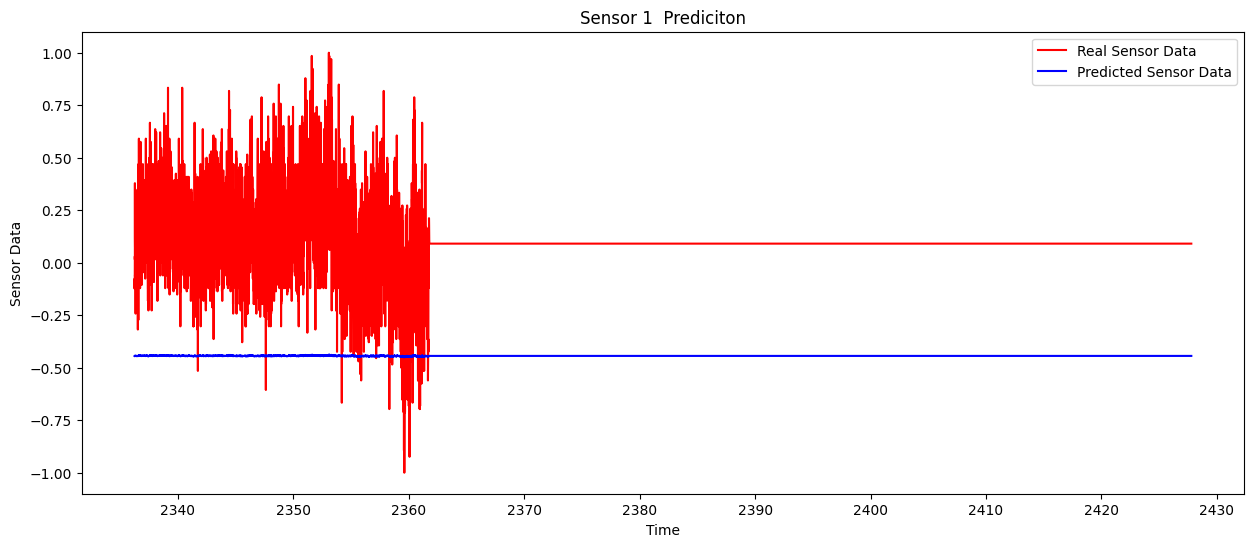

In [72]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(leak_data[['Normalized Sensor 1']][len(leak_data[['Normalized Sensor 1']])-len(y_test):].index, y_test, color = 'red', label = 'Real Sensor Data')
axes.plot(leak_data[['Normalized Sensor 1']][len(leak_data[['Normalized Sensor 1']])-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Sensor Data')
plt.title('Sensor 1  Prediciton')
plt.xlabel('Time')
plt.ylabel('Sensor Data')
plt.legend()
plt.show()